In [2]:
import numpy as np
import pandas as pd
import re

In [7]:
path_products = os.path.abspath("../datasets/predict_categories_dataset_products.jsonl.gz")
path_dataset = os.path.abspath("dataset/dataset.pkl")


In [4]:
"""approx time 40sec"""
from IPython.display import clear_output
import gzip
import json
# make df from json
rows = []
with gzip.open(path_products) as f:
    for i, line in enumerate(f):
        json_line = json.loads(line)
        code = json_line['code']
        categories_tags = json_line['categories_tags']
        rows.append([code, categories_tags])

df_categories = pd.DataFrame(rows, columns = ["code", "categories_tags"]).set_index("code", drop = True)

In [18]:
df = pd.read_pickle(path_dataset)
empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df = df[~empty_or_noise]
dataset = df[["code", "word_selection"]]
dataset = dataset.merge(df_categories, left_on="code", right_on="code")
print(dataset.shape)
del df
del df_categories


noise or empty lines: 194
(596366, 3)


In [19]:
dataset.head()

,code,word_selection,categories_tags
0,0021065000071,Facts Calories Nutrition servings container Se...,"[en:groceries, en:sauces]"
1,0021065000101,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,"[en:groceries, en:sauces, en:hot-sauces]"
2,0021078019091,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,"[en:dietary-supplements, en:bodybuilding-suppl..."
3,0021110336001,Whole Sighature MAD White Potatoes SEA kitchen...,"[en:plant-based-foods-and-beverages, en:plant-..."
4,0021130008124,DISTRIBUTED BY Nutrition Facts SAFEWAY INC PO ...,"[en:groceries, en:sauces, en:tomato-sauces, en..."


In [20]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [21]:
from tqdm import tqdm
embeddings_list = []
append = embeddings_list.append
for text in tqdm(dataset["word_selection"]):
    append(model.encode(text))

100%|██████████| 596366/596366 [3:39:07<00:00, 45.36it/s]  


In [22]:
"""
import pickle
with open('embeddings.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(embeddings_list, file)
"""

In [ ]:
import pickle
with open('embeddings.pkl', 'rb') as file:
    # A new file will be created
    pickle.load(file)

In [ ]:
### Make labels
#from sklearn.preprocessing import MultiLabelBinarizer
#mlb = MultiLabelBinarizer()
#y_multilabels = mlb.fit_transform([eval(item) for item in dataset["categories_tags"]])

In [55]:
np.sum(meats_)

52925

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [116]:
from sklearn.metrics import classification_report

X = np.array(embeddings_list)
y = np.array(meats_).ravel()
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500)


clf.fit(X,y)

#y_pred = knn.predict(X)
y_pred = clf.predict(X)

print(classification_report(y_pred, y))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    565143
           1       0.47      0.79      0.59     31223

    accuracy                           0.94    596366
   macro avg       0.73      0.87      0.78    596366
weighted avg       0.96      0.94      0.95    596366



In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [405]:
dataset["word_selection"]

,code,word_selection,categories_tags,category_normalized
0,0021065000071,Facts Calories Nutrition servings container Se...,"[en:groceries, en:sauces]",[en:sauces]
1,0021065000101,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,"[en:groceries, en:sauces, en:hot-sauces]","[en:sauces, en:hot-sauces]"
2,0021078019091,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,"[en:dietary-supplements, en:bodybuilding-suppl...","[en:dietary-supplements, en:bodybuilding-suppl..."
3,0021110336001,Whole Sighature MAD White Potatoes SEA kitchen...,"[en:plant-based-foods-and-beverages, en:plant-...","[en:plant-based-foods-and-beverages, en:plant-..."
4,0021130008124,DISTRIBUTED BY Nutrition Facts SAFEWAY INC PO ...,"[en:groceries, en:sauces, en:tomato-sauces, en...","[en:sauces, en:tomato-sauces, en:ketchup]"
...,...,...,...,...
596361,3700701300290,. sel. . VALEURS NUTRITIONNELLES MOYENNES en p...,"[en:snacks, en:sweet-snacks, en:biscuits-and-c...","[en:snacks, en:sweet-snacks, en:biscuits-and-c..."
596362,7802220650002,. . . ENVAE BOGAR LIAPYAR INGREDIENTES Trigo D...,"[en:plant-based-foods-and-beverages, en:plant-...","[en:plant-based-foods-and-beverages, en:plant-..."
596363,0781718996204,. . jose. Ingredientes Miel Abeja Duración Ind...,"[en:breakfasts, en:spreads, en:sweet-spreads, ...","[en:breakfasts, en:spreads, en:sweet-spreads, ..."
596364,3258565412401,. . . Ao NE JAMAIS seo best before Par portion...,"[en:plant-based-foods-and-beverages, en:plant-...","[en:plant-based-foods-and-beverages, en:plant-..."


In [160]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.9.0
Eager mode:  True
GPU is available


### Bert

In [408]:
dataset["word_selection"].shape

(572141,)

In [411]:
categories_freq = {}
for categories_list in dataset["categories_tags"]:
    for category in categories_list:
        if category in categories_freq:
            categories_freq[category]+=1
        else:
            categories_freq[category]=1

def sort_dict(dict_):
    return {k:v for k,v in sorted(dict_.items(), key = lambda x: x[1], reverse = True)}
#sort_dict(categories_freq)

def fill_cat(categories_list, cat_to_match, list_):
    if cat_to_match in categories_list:
        list_.append([1])
    else:
        list_.append([0])
    return list_

#'en:sweet-snacks'
#'en:meats'
#'en:brown-rices'

sweet_snacks = []
meats_ = []
brown_rices = []
for categories_list in dataset["categories_tags"]:
    sweet_snacks = fill_cat(categories_list, 'en:sweet-snacks', sweet_snacks)
    meats_ = fill_cat(categories_list, 'en:meats', meats_)
    brown_rices = fill_cat(categories_list, 'en:brown-rices', brown_rices)

2022-06-01 00:31:05.901258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [413]:
y = np.array(meats_)
y[:5], y.shape


(array([[0],
        [0],
        [0],
        [0],
        [0]]),
 (572141, 1))

In [414]:
### Make df
X = dataset["word_selection"]
y = np.array(meats_).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(64)
test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test)).batch(64)


In [390]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')


In [350]:
max_length = dataset["word_selection"].str.split().str.len().max()
max_length

240

In [364]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3"
#https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
#Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3

In [376]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2022-05-31 23:50:33.211760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [391]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [392]:
model = build_classifier_model()

2022-06-01 00:07:35.976289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [396]:
with tf.device('/cpu:0'):
    text_test = ["mother of dragons"]
    bert_raw_result = model(tf.constant(text_test))
    print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.34575933]], shape=(1, 1), dtype=float32)


In [398]:
with tf.device('/cpu:0'):
    text_test = ['this is such an amazing movie!']
    text_preprocessed = bert_preprocess_model(text_test)

    print(f'Keys       : {list(text_preprocessed.keys())}')
    print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
    print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
    print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
    print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 10531 10124 11049 10151 28149 19308 18379   106   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


2022-06-01 00:10:29.722196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [402]:
#tf.keras.utils.plot_model(model)

In [420]:
metrics = [
      #macro_f1,
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tfa.metrics.F1Score(num_classes= N_LABELS, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [419]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train,
                            validation_data=test,
                            epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/5


2022-06-01 00:42:28.385593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


NotFoundError: Graph execution error:

No registered 'AddN' OpKernel for 'GPU' devices compatible with node {{node model_1/preprocessing/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/bert_pack_inputs/PartitionedCall/RaggedConcat/ArithmeticOptimizer/AddOpsRewrite_Leaf_0_add_2}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: N=2, T=DT_INT64, _XlaHasReferenceVars=false, _grappler_ArithmeticOptimizer_AddOpsRewriteStage=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, 16534343205130372495, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64, DT_VARIANT]
  device='GPU'; T in [DT_FLOAT]
  device='DEFAULT'; T in [DT_INT32]
  device='CPU'; T in [DT_UINT64]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_UINT32]
  device='CPU'; T in [DT_UINT16]
  device='CPU'; T in [DT_INT16]
  device='CPU'; T in [DT_UINT8]
  device='CPU'; T in [DT_INT8]
  device='CPU'; T in [DT_INT32]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_VARIANT]

	 [[model_1/preprocessing/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/bert_pack_inputs/PartitionedCall/RaggedConcat/ArithmeticOptimizer/AddOpsRewrite_Leaf_0_add_2]] [Op:__inference_train_function_3373576]

<AxesSubplot:>

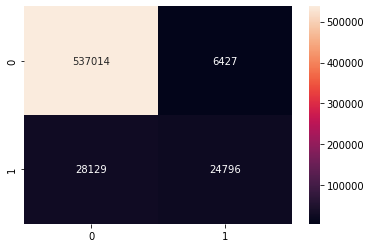

In [117]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot = True, fmt = ".0f")

In [115]:
y_pred_1 = y_pred == 1
y_true_0 = y == 1

dataset.iloc[(y_pred_1 & y_true_0)]

,code,word_selection,categories_tags
55,0021130153503,TO OPEN YEAH Aekoss BERFORATION SAFEWAY farms ...,"[en:meats, en:prepared-meats, en:hams, en:pork]"
145,0021357020138,Our Signature BEEF HICKORY SAUSAGE FARMS NATUR...,"[en:meats, en:prepared-meats, en:beef, en:saus..."
146,0021357913447,HICKORY FARMS EST Farmuhoase Recipe SUMMER Har...,"[en:meats, en:prepared-meats, en:beef, en:saus..."
273,0022655306313,ll natural NEW LOOK AME GREAT ASTE BUTTERBALL ...,"[en:meats, en:prepared-meats, en:sausages, en:..."
274,0022655702054,natural all GROUND TURKEY BUTTERBALL LEAN FRES...,"[en:meats, en:poultries]"
...,...,...,...
596277,5054781854739,. refrigerated in by and recycling both use st...,"[en:meats, en:beef, en:beef-steaks]"
596322,7037203626679,. leverpostei uten ovnsbakt bacon melk. . Ovns...,"[en:meats, en:pork, en:pork-liver]"
596346,3569380727305,. . . TERRINE CANARD AU MAGRET CANARD FUME VIA...,"[en:meats, en:prepared-meats, en:meat-based-pr..."
596347,2487374021844,. . au. Suggestion présentation Halt Molenporc...,"[en:meats, en:poultries, en:chickens, en:chick..."


In [65]:
dataset["categories_tags"].str.len().sort_values()

87818      1
337272     1
337271     1
38787      1
337270     1
          ..
449258    32
433319    33
547188    40
455505    41
203090    43
Name: categories_tags, Length: 596366, dtype: int64

In [68]:
categories = dataset["categories_tags"][0]

In [71]:
set.intersection(set(categories), set(categories)) == set(categories)

True

In [72]:
dataset["code"][0]

'0021065000071'

In [409]:
## keep only normalized categories
from tqdm import tqdm
import urllib.request, json 
with urllib.request.urlopen("https://static.openfoodfacts.org/data/taxonomies/categories.json") as url:
    normalized_categories_dict = json.loads(url.read().decode())

def get_normalizerd_categories_and_frequent_ones(category_list, normalized_categories_dict, categories_with_more_than_n_occurences):
  category_selection = []
  for list_ in tqdm(category_list):
    categories_normalized = [
                             category for category in list_ if (
                                 category in normalized_categories_dict 
                                 and category in categories_with_more_than_n_occurences
                                 )]
    category_selection.append(categories_normalized)
  return category_selection

def get_freq_dict(category_list):
  cat_dict = {}
  for list_ in category_list:
    if isinstance(list_, str):
      list_ = eval(list_)
    for category in list_:
      if category in cat_dict:
        cat_dict[category] += 1
      else:
        cat_dict[category] = 1
  return cat_dict

def get_categories_with_more_than_n_occurencs(category_list, freq_dict, n_freq = 49):
  categories_with_more_than_n_occurences = [cat for (cat, freq) in freq_dict.items() if freq > n_freq]
  return categories_with_more_than_n_occurences

freq_dict = get_freq_dict(dataset["categories_tags"])
frequent_categories = get_categories_with_more_than_n_occurencs(dataset["categories_tags"], freq_dict, n_freq = 49)
category_normalized = get_normalizerd_categories_and_frequent_ones(dataset["categories_tags"], normalized_categories_dict, frequent_categories)
dataset["category_normalized"] = category_normalized
filter = dataset["category_normalized"].str.len() != 0
dataset = dataset.loc[filter, :].copy()

100%|██████████| 572141/572141 [00:07<00:00, 72755.24it/s] 


In [201]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output = True)

y_labels_matrix =  mlb.fit_transform(dataset["category_normalized"])

In [189]:
dataset.head()

,code,word_selection,categories_tags,category_normalized
0,0021065000071,Facts Calories Nutrition servings container Se...,"[en:groceries, en:sauces]",[en:sauces]
1,0021065000101,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,"[en:groceries, en:sauces, en:hot-sauces]","[en:sauces, en:hot-sauces]"
2,0021078019091,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,"[en:dietary-supplements, en:bodybuilding-suppl...","[en:dietary-supplements, en:bodybuilding-suppl..."
3,0021110336001,Whole Sighature MAD White Potatoes SEA kitchen...,"[en:plant-based-foods-and-beverages, en:plant-...","[en:plant-based-foods-and-beverages, en:plant-..."
4,0021130008124,DISTRIBUTED BY Nutrition Facts SAFEWAY INC PO ...,"[en:groceries, en:sauces, en:tomato-sauces, en...","[en:sauces, en:tomato-sauces, en:ketchup]"


In [276]:
dataset.head(2)

,code,word_selection,categories_tags,category_normalized
0,0021065000071,Facts Calories Nutrition servings container Se...,"[en:groceries, en:sauces]",[en:sauces]
1,0021065000101,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,"[en:groceries, en:sauces, en:hot-sauces]","[en:sauces, en:hot-sauces]"
